<a href="https://colab.research.google.com/github/Vishalg19/PROACTIVE-NATURAL-CALAMITIES-PREDICTION-AND-MITIGATION-USING-DEEP-LEARNING/blob/main%2FVishalg19%2FVishalg19.github.io/Earthquake_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Time Parsing:
First, you need to convert date_time into a more usable format. Extract features like year, month, day, and time. In Python, you can use the pandas library for this.

In [ ]:
import pandas as pd
from google.colab import files

# Upload files
uploaded = files.upload()

# Assuming you're uploading a CSV file. Adjust the following line if it's a different format.
# Replace 'your_file.csv' with the actual filename after uploading.
filename = next(iter(uploaded))
df = pd.read_csv(filename)

# Ensure 'date_time' column is present in DataFrame
if 'date_time' in df.columns:
    # Convert 'date_time' column to datetime
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

    # Extract components from the date_time column
    df['year'] = df['date_time'].dt.year
    df['month'] = df['date_time'].dt.month
    df['day'] = df['date_time'].dt.day
    df['hour'] = df['date_time'].dt.hour
    df['minute'] = df['date_time'].dt.minute
else:
    print("Error: 'date_time' column not found in the uploaded file.")


Saving earthquake_data.csv to earthquake_data (1).csv


2. Categorical Encoding:
For categorical variables, one-hot encoding is a common approach. It converts categorical data into a form that could be provided to ML algorithms to do a better job in prediction.



In [ ]:
# Example for one-hot encoding using pandas
categorical_columns = ['alert', 'magType', 'location', 'continent', 'country']
df = pd.get_dummies(df, columns=categorical_columns)


3. Normalization:
Normalization is crucial for numerical features to ensure that they're on a similar scale, especially for algorithms that are sensitive to the scale of input data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical_columns = ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


4. Graph Construction:
For graph construction, you'll need to decide the rules for creating nodes and edges.

Nodes: Each earthquake event can be a node.
Edges: There are several ways to define edges. Two straightforward methods are:
Temporal Proximity: Connect events that are close in time. For instance, an edge between events that occurred within a certain timeframe.
Geographical Proximity: Connect events that are geographically close. This could be based on latitude and longitude data.
The choice of how to construct the graph will depend on the specifics of your project goals and the nature of the seismic data. For instance:

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers
    return c * r

def is_geographically_close(event_i, event_j, threshold=100):
    """
    Check if two events are within a certain distance threshold.
    Threshold is in kilometers.
    """
    distance = haversine(event_i['longitude'], event_i['latitude'], event_j['longitude'], event_j['latitude'])
    return distance < threshold

# Assuming df is your pandas DataFrame with columns 'latitude' and 'longitude'

# Create an empty graph
G = nx.Graph()

# Add nodes
for i, row in df.iterrows():
    G.add_node(i, **row.to_dict())

# Add edges based on geographical proximity
for i, event_i in df.iterrows():
    for j, event_j in df.iterrows():
        if i != j and is_geographically_close(event_i, event_j):
            G.add_edge(i, j)

# Now G is your graph based on geographical proximity


1. Define GNN Architecture:
Let's create a simple GNN model using Graph Convolutional Layers (GCNs). This model assumes that your graph nodes represent earthquake events, and edges represent geographical proximity.

In [ ]:
pip install geopandas networkx

In [ ]:
import geopandas as gpd
import networkx as nx

# Assuming df is your pandas DataFrame with columns 'latitude' and 'longitude'
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

# Create a spatial index for efficient spatial queries
sindex = gdf.sindex

# Function to efficiently find neighbors based on spatial proximity
def find_neighbors(event_id, threshold=100):
    event = gdf.iloc[event_id]
    possible_matches_index = list(sindex.intersection(event.geometry.buffer(threshold).bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    return possible_matches[possible_matches.index != event_id]

# Create an empty graph
G = nx.Graph()

# Add nodes
for i, row in gdf.iterrows():
    G.add_node(i, **row.to_dict())

# Add edges based on geographical proximity
for i, event_i in gdf.iterrows():
    neighbors = find_neighbors(i)
    for j, event_j in neighbors.iterrows():
        G.add_edge(i, j)

# Now G is your graph based on geographical proximity


1. Visualize the Graph:
Use a graph visualization library, such as matplotlib or networkx for a simple graph, or more specialized libraries like pyvis or plotly for interactive visualizations. This step can help you understand the structure of the graph and how earthquakes are connected based on geographical proximity.

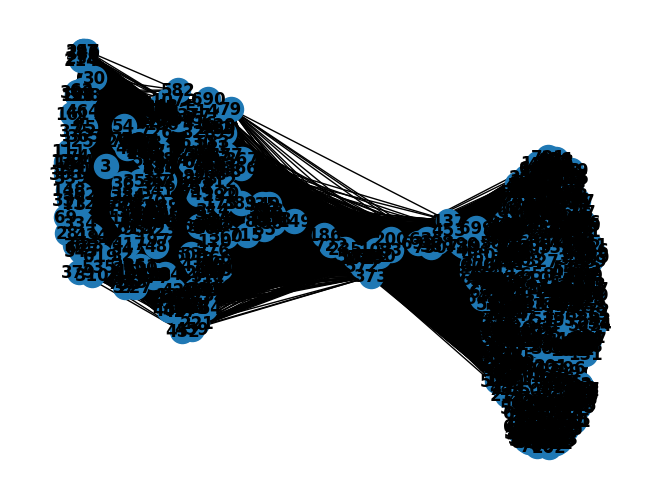

In [ ]:
import matplotlib.pyplot as plt

# Visualize the graph
pos = nx.spring_layout(G)  # You can use different layout algorithms
nx.draw(G, pos, with_labels=True, font_weight='bold')
plt.show()

2. Descriptive Analysis:
Perform a descriptive analysis of the graph to extract insights. This may include computing basic statistics such as the number of nodes, edges, or identifying central nodes.

In [ ]:
# Basic graph statistics
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Identify central nodes
centrality = nx.degree_centrality(G)
central_nodes = [node for node, centrality_value in centrality.items() if centrality_value > 0.5]
print("Central nodes:", central_nodes)


Number of nodes: 782
Number of edges: 156804
Central nodes: [0, 1, 4, 5, 6, 10, 11, 12, 13, 14, 16, 19, 22, 23, 24, 25, 26, 31, 39, 40, 41, 43, 45, 46, 51, 58, 61, 65, 66, 67, 68, 71, 72, 76, 77, 78, 80, 81, 89, 90, 91, 92, 94, 95, 98, 101, 102, 105, 106, 109, 110, 113, 114, 116, 119, 121, 122, 123, 124, 126, 130, 131, 132, 139, 140, 142, 143, 145, 146, 154, 155, 156, 157, 159, 160, 162, 163, 164, 165, 167, 169, 171, 173, 176, 177, 178, 179, 180, 185, 187, 188, 191, 193, 194, 195, 196, 199, 201, 202, 203, 206, 207, 209, 210, 213, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 228, 229, 231, 232, 233, 234, 236, 237, 239, 240, 241, 242, 243, 244, 249, 251, 252, 253, 254, 255, 256, 257, 258, 261, 262, 263, 265, 266, 270, 272, 275, 277, 278, 279, 280, 287, 288, 289, 291, 293, 294, 295, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 311, 312, 313, 315, 318, 319, 320, 321, 322, 323, 324, 327, 329, 331, 333, 336, 342, 344, 345, 347, 348, 349, 351, 352, 359, 361, 362, 364, 369,

3. Implement Graph Neural Network (GNN):
If your ultimate goal is to predict earthquake-related outcomes, you might want to implement and train a Graph Neural Network. This involves converting the graph into a format suitable for a GNN library like PyTorch Geometric.

In [ ]:
pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.7 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.data import Data
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Create a simple graph for illustration
G = nx.Graph()
G.add_node(0, latitude=1.0, target_variable=0.5)
G.add_node(1, latitude=2.0, target_variable=1.2)
G.add_edge(0, 1)

# Convert the graph to a PyTorch Geometric Data object
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.tensor([[G.nodes[node]['latitude']] for node in G.nodes], dtype=torch.float)

# Extract target variable if present, else set it to a default value (e.g., 0)
target_key = 'target_variable'
default_value = 0.0
y = torch.tensor([G.nodes[node].get(target_key, default_value) for node in G.nodes], dtype=torch.float)

data = Data(x=x, edge_index=edge_index, y=y)

# Define and train your GNN model
class GNNModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return x

# Instantiate the model
model = GNNModel(in_channels=1, out_channels=1)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, data.y.view(-1, 1))
    loss.backward()
    optimizer.step()

# Evaluate the trained model
# ...


1 Model Evluation

In [ ]:
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

# Replace these values with the actual dimensions of your data
num_nodes = 100  # Number of nodes in your graph
num_features = 3  # Number of features for each node
edges = [(0, 1), (1, 2), (2, 0)]  # Example: define the edges of your graph

# Assuming 'data' is your PyTorch Geometric Data object
data = Data(x=torch.randn((num_nodes, num_features)),
            edge_index=torch.tensor(edges, dtype=torch.long).t().contiguous(),
            y=torch.randn((num_nodes, 1)))

In [ ]:
from torch.utils.data import Subset, random_split

# Assuming 'data' is your PyTorch Geometric Data object

# Define the sizes for train, validation, and test sets
train_size = int(0.7 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

# Generate indices for the subsets
indices = list(range(len(data)))
train_indices, val_indices, test_indices = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]

# Create Subset datasets
train_data = Subset(data, train_indices)
val_data = Subset(data, val_indices)
test_data = Subset(data, test_indices)


Metrics

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
from torch.utils.data import Subset
from sklearn.metrics import mean_squared_error

# Assuming 'data' is your PyTorch Geometric Data object
num_nodes = 100  # Number of nodes in your graph
num_features = 3  # Number of features for each node
edges = [(0, 1), (1, 2), (2, 0)]  # Example: define the edges of your graph

data = Data(x=torch.randn((num_nodes, num_features)),
            edge_index=torch.tensor(edges, dtype=torch.long).t().contiguous(),
            y=torch.randn((num_nodes, 1)))

# Define the sizes for train, validation, and test sets
train_size = int(0.7 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

# Generate indices for the subsets
indices = list(range(len(data)))
train_indices, val_indices, test_indices = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]

# Create Subset datasets
train_data = Subset(data, train_indices)
val_data = Subset(data, val_indices)
test_data = Subset(data, test_indices)

# Assuming the following GNN model
class GNNModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return x

# Instantiate the model
model = GNNModel(in_channels=num_features, out_channels=1)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

batch_size = 1
indices = list(range(len(train_data)))

epochs = 50
for epoch in range(epochs):
    model.train()
    random.shuffle(indices)

    for start_idx in range(0, len(train_data), batch_size):
        end_idx = min(start_idx + batch_size, len(train_data))
        batch_indices = indices[start_idx:end_idx]

        batch_data = [train_data[i] for i in batch_indices]
        batch = Batch.from_data_list(batch_data)  # Assuming you have the `Batch` class

        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y.view(-1, 1))  # Ensure batch.y is a 2D tensor
        loss.backward()
        optimizer.step()


KeyError: 0